In [1]:
#!/usr/bin/env python
# coding: utf-8

# NFL Offensive Identity Analysis<br>
<br>
This notebook analyzes offensive identities across the NFL using clustering techniques to identify distinctive offensive philosophies.

## Setup and Data Loading

In[ ]:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
import sys

/var/folders/cq/dyx2ttcj47lckh2j68_y1qn80000gn/T/ipykernel_39132/2990321255.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Add the parent directory to the path so we can import our scripts

In [3]:
sys.path.append('..')
from scripts.data_loader import load_pbp_data, get_team_colors
from scripts.visualizations import plot_team_run_pass_ratio, plot_down_distance_heatmap

Set plot style

In [4]:
plt.style.use('ggplot')
sns.set_palette('colorblind')

Load the data

In [5]:
data_path = '../data/pbp-2024.csv'
df = load_pbp_data(data_path)
print(f"Loaded {len(df):,} plays from the 2024 NFL season")

Loaded 53,283 plays from the 2024 NFL season


## Feature Engineering for Offensive Identity

In [6]:
def create_offensive_features(df):
    """
    Create features that capture offensive identity for each team.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Play-by-play dataframe
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with offensive features by team
    """
    # Filter for relevant plays
    play_df = df[
        (df['PlayType'].isin(['PASS', 'RUSH'])) & 
        (~pd.isna(df['OffenseTeam'])) &
        (~pd.isna(df['Down'])) &
        (~pd.isna(df['ToGo']))
    ]
    
    # Group by team and calculate features
    team_features = []
    
    for team in play_df['OffenseTeam'].unique():
        team_data = play_df[play_df['OffenseTeam'] == team]
        
        # Basic play type ratios
        total_plays = len(team_data)
        pass_ratio = len(team_data[team_data['PlayType'] == 'PASS']) / total_plays
        rush_ratio = len(team_data[team_data['PlayType'] == 'RUSH']) / total_plays
        
        # Down-specific tendencies
        first_down_pass_ratio = len(team_data[(team_data['Down'] == 1) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['Down'] == 1])
        second_down_pass_ratio = len(team_data[(team_data['Down'] == 2) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['Down'] == 2])
        third_down_pass_ratio = len(team_data[(team_data['Down'] == 3) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['Down'] == 3])
        
        # Distance-specific tendencies
        short_yardage_pass_ratio = len(team_data[(team_data['ToGo'] <= 3) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['ToGo'] <= 3])
        medium_yardage_pass_ratio = len(team_data[(team_data['ToGo'].between(4, 7)) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['ToGo'].between(4, 7)])
        long_yardage_pass_ratio = len(team_data[(team_data['ToGo'] > 7) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['ToGo'] > 7])
        
        # Field position tendencies
        own_territory_pass_ratio = len(team_data[(team_data['field_position'] < 50) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['field_position'] < 50])
        opponent_territory_pass_ratio = len(team_data[(team_data['field_position'] >= 50) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['field_position'] >= 50])
        
        # Red zone tendencies
        red_zone_pass_ratio = len(team_data[(team_data['is_redzone']) & (team_data['PlayType'] == 'PASS')]) / len(team_data[team_data['is_redzone']])
        
        # Success rates
        pass_success_rate = len(team_data[(team_data['PlayType'] == 'PASS') & (team_data['SeriesFirstDown'] == 1)]) / len(team_data[team_data['PlayType'] == 'PASS'])
        rush_success_rate = len(team_data[(team_data['PlayType'] == 'RUSH') & (team_data['SeriesFirstDown'] == 1)]) / len(team_data[team_data['PlayType'] == 'RUSH'])
        
        # Create feature dictionary
        features = {
            'Team': team,
            'Pass_Ratio': pass_ratio,
            'Rush_Ratio': rush_ratio,
            'First_Down_Pass_Ratio': first_down_pass_ratio,
            'Second_Down_Pass_Ratio': second_down_pass_ratio,
            'Third_Down_Pass_Ratio': third_down_pass_ratio,
            'Short_Yardage_Pass_Ratio': short_yardage_pass_ratio,
            'Medium_Yardage_Pass_Ratio': medium_yardage_pass_ratio,
            'Long_Yardage_Pass_Ratio': long_yardage_pass_ratio,
            'Own_Territory_Pass_Ratio': own_territory_pass_ratio,
            'Opponent_Territory_Pass_Ratio': opponent_territory_pass_ratio,
            'Red_Zone_Pass_Ratio': red_zone_pass_ratio,
            'Pass_Success_Rate': pass_success_rate,
            'Rush_Success_Rate': rush_success_rate
        }
        
        team_features.append(features)
    
    return pd.DataFrame(team_features)

Create offensive features

In [7]:
offensive_features = create_offensive_features(df)
print("\nOffensive Features by Team:")
print(offensive_features)


Offensive Features by Team:
   Team  Pass_Ratio  Rush_Ratio  First_Down_Pass_Ratio  \
0    GB    0.507407    0.492593               0.376016   
1   MIN    0.592837    0.407163               0.435052   
2   CIN    0.665063    0.334937               0.542977   
3   PIT    0.529131    0.470869               0.406181   
4    TB    0.577570    0.422430               0.490272   
5   JAX    0.597266    0.402734               0.464286   
6   ATL    0.552336    0.447664               0.414433   
7   WAS    0.560669    0.439331               0.441121   
8   NYG    0.620553    0.379447               0.583524   
9   IND    0.541294    0.458706               0.454545   
10  TEN    0.571574    0.428426               0.445701   
11  BUF    0.541632    0.458368               0.415270   
12  NYJ    0.648430    0.351570               0.536364   
13   NO    0.585341    0.414659               0.492925   
14   LA    0.580927    0.419073               0.523166   
15  SEA    0.642713    0.357287            

## Clustering Analysis

Prepare data for clustering

In [8]:
X = offensive_features.drop('Team', axis=1)

Standardize features

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Determine optimal number of clusters using elbow method

In [10]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

Plot elbow curve

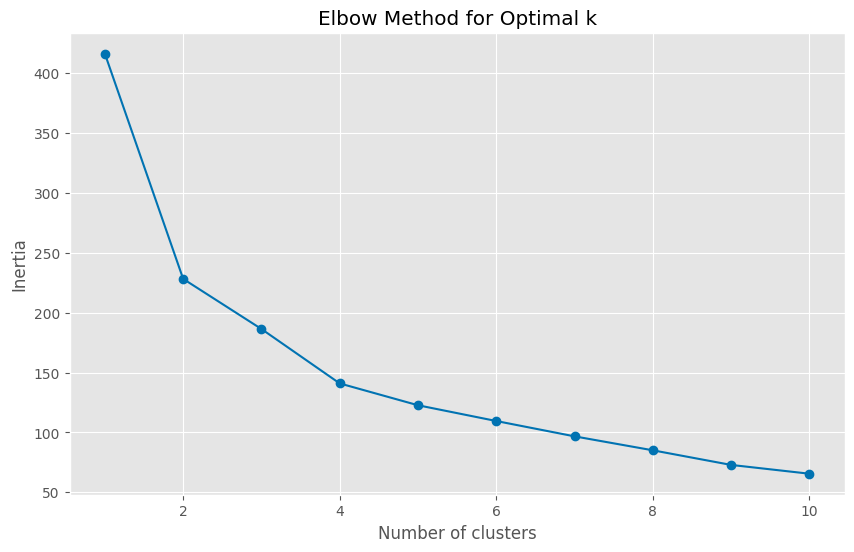

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Perform clustering with optimal k (let's say 4 based on elbow method)

In [12]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

Add cluster labels to features

In [13]:
offensive_features['Cluster'] = clusters

## Visualization of Clusters

Perform PCA for visualization

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Create scatter plot

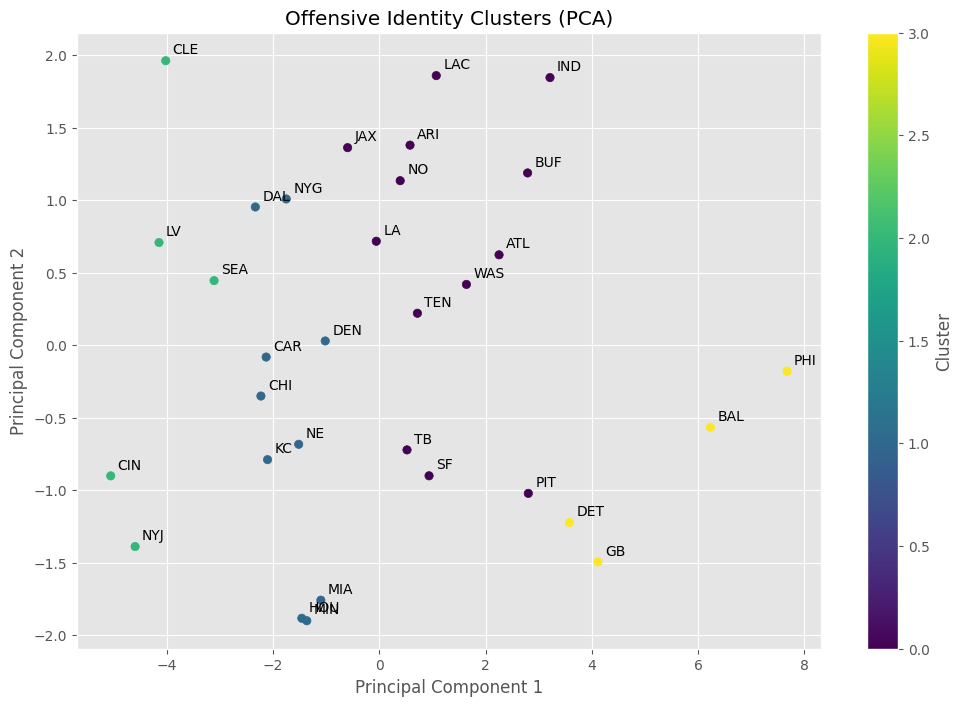

In [15]:


plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')

for i, team in enumerate(offensive_features['Team']):
    plt.annotate(team, (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points')
    
plt.title('Offensive Identity Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

## Cluster Analysis

Analyze cluster characteristics

In [16]:
cluster_means = offensive_features.groupby('Cluster').mean(numeric_only=True)
cluster_means.head()

,Pass_Ratio,Rush_Ratio,First_Down_Pass_Ratio,Second_Down_Pass_Ratio,Third_Down_Pass_Ratio,Short_Yardage_Pass_Ratio,Medium_Yardage_Pass_Ratio,Long_Yardage_Pass_Ratio,Own_Territory_Pass_Ratio,Opponent_Territory_Pass_Ratio,Red_Zone_Pass_Ratio,Pass_Success_Rate,Rush_Success_Rate
Cluster,,,,,,,,,,,,,
0,0.566011,0.433989,0.460072,0.599754,0.750273,0.366502,0.638722,0.587822,0.605381,0.524709,0.486162,0.323010,0.249908
1,0.607353,0.392647,0.496446,0.617045,0.825573,0.480160,0.667593,0.615649,0.617042,0.595552,0.576404,0.306316,0.211340
2,0.653592,0.346408,0.571030,0.663465,0.823698,0.495531,0.729010,0.662105,0.655476,0.649686,0.622598,0.315790,0.212804
3,0.495356,0.504644,0.391935,0.523507,0.703527,0.325483,0.562566,0.512826,0.507655,0.483483,0.455686,0.375320,0.268889


Plot cluster characteristics

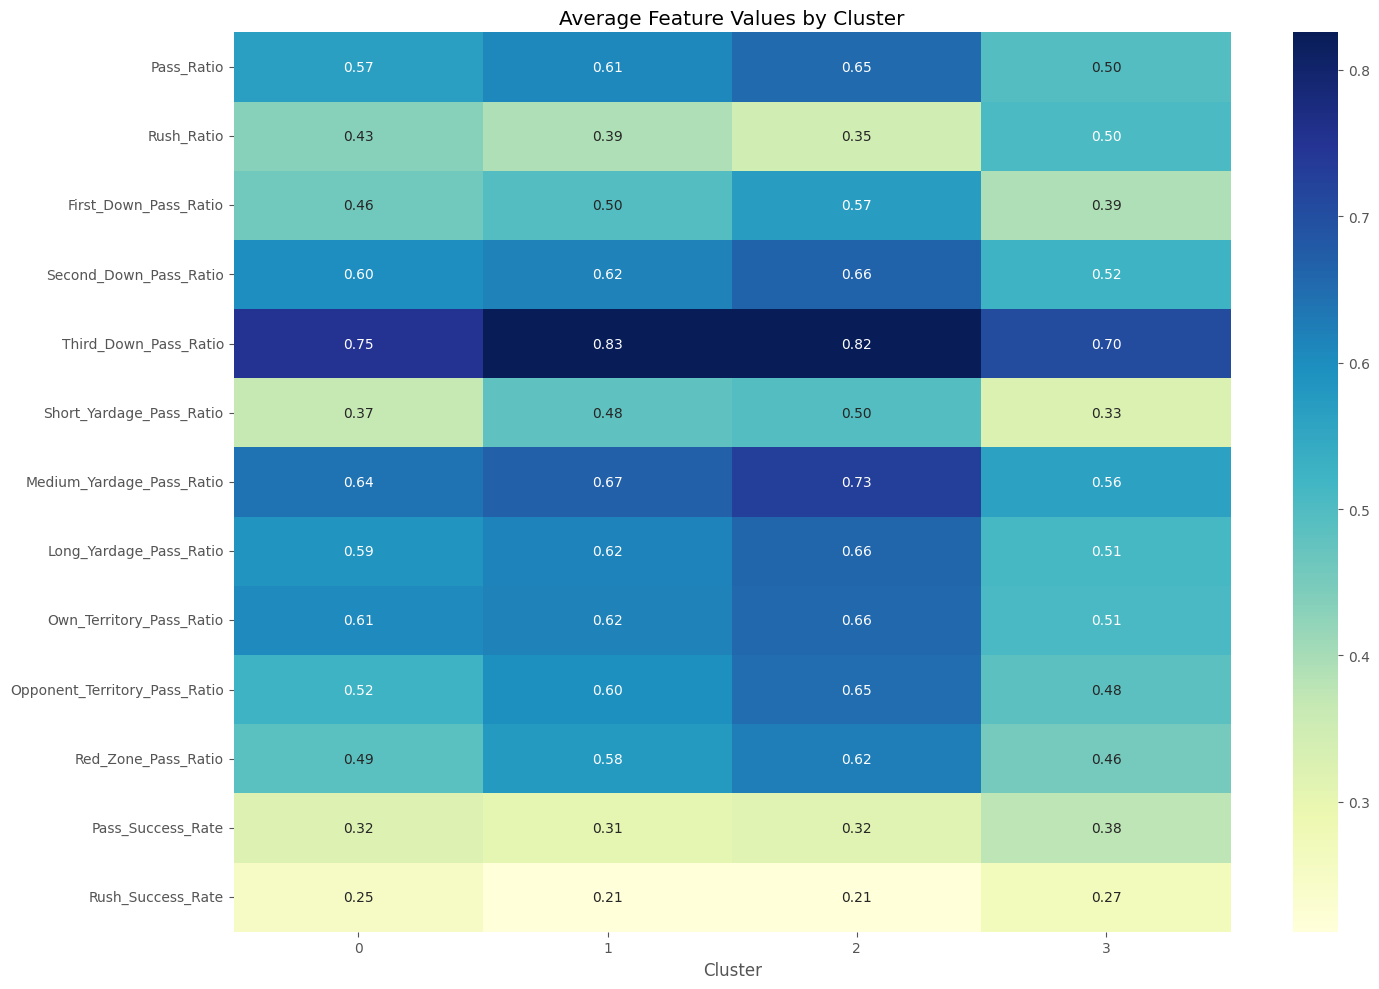

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(cluster_means.T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Feature Values by Cluster')
plt.tight_layout()
plt.show()

Print team clusters

In [18]:
print("\nTeams by Cluster:")
for cluster in range(4):
    cluster_teams = offensive_features[offensive_features['Cluster'] == cluster]['Team'].tolist()
    print(f"\nCluster {cluster}:")
    print(", ".join(cluster_teams))


Teams by Cluster:

Cluster 0:
PIT, TB, JAX, ATL, WAS, IND, TEN, BUF, NO, LA, ARI, LAC, SF

Cluster 1:
MIN, NYG, CHI, HOU, KC, DAL, DEN, NE, MIA, CAR

Cluster 2:
CIN, NYJ, SEA, CLE, LV

Cluster 3:
GB, BAL, DET, PHI


## Cluster Interpretation

Create radar chart for cluster characteristics

In [19]:
def create_radar_chart(cluster_data, title):
    categories = cluster_data.index
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axe per variable
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    plt.ylim(0, 1)
    
    # Plot data
    values = cluster_data.values
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)
    
    plt.title(title, size=11, color='black', y=1.1)
    plt.tight_layout()

Create radar charts for each cluster

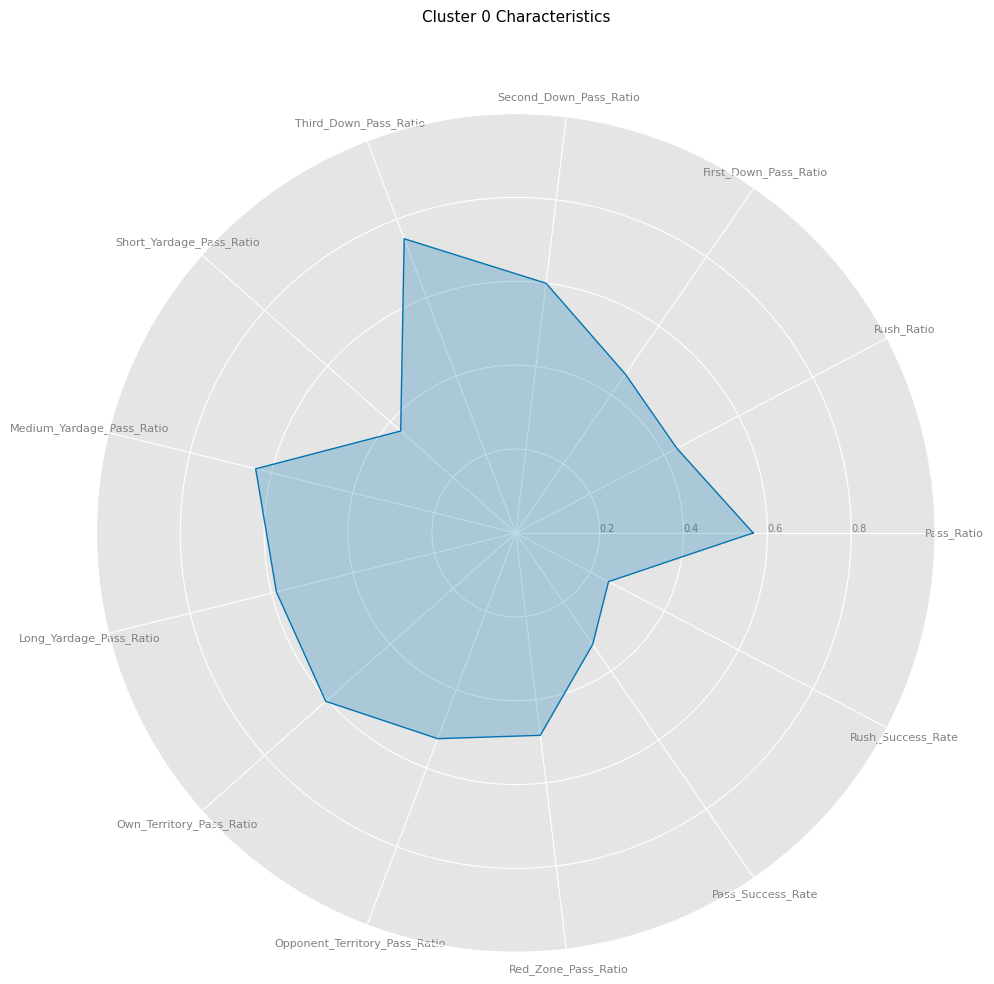

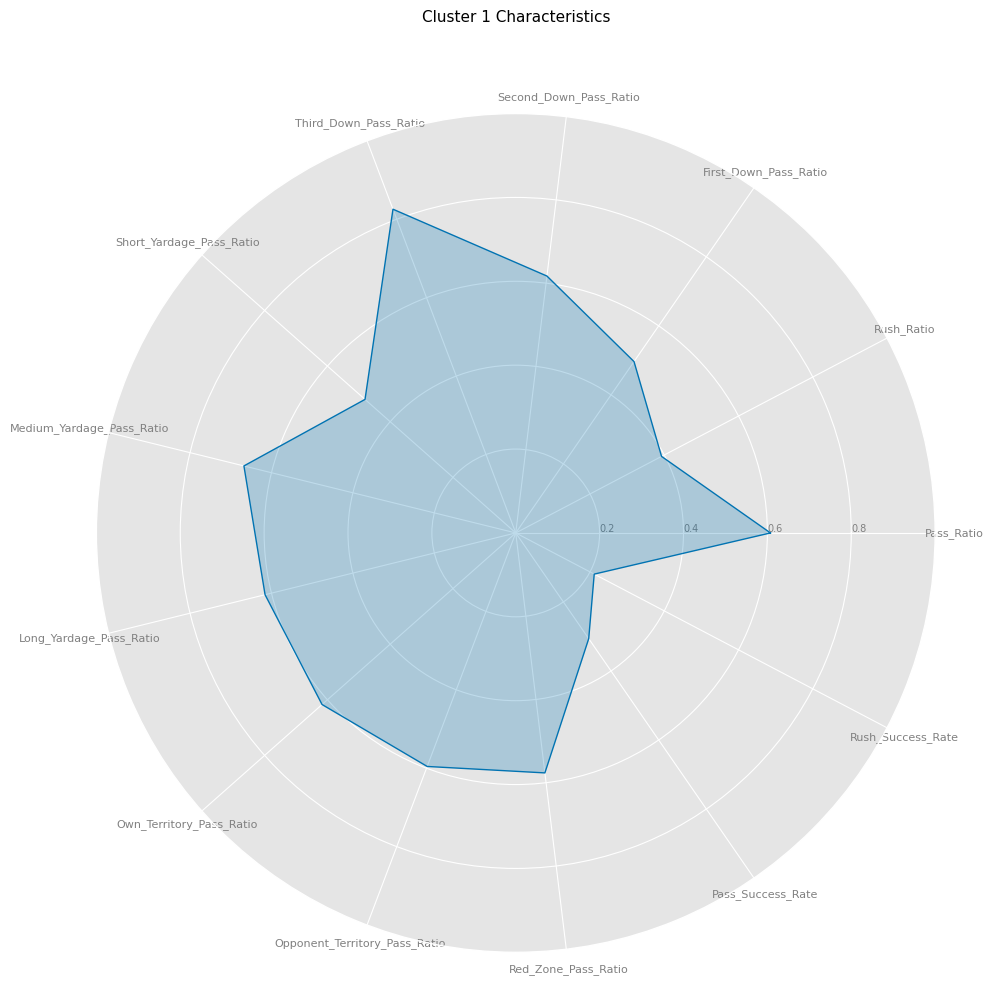

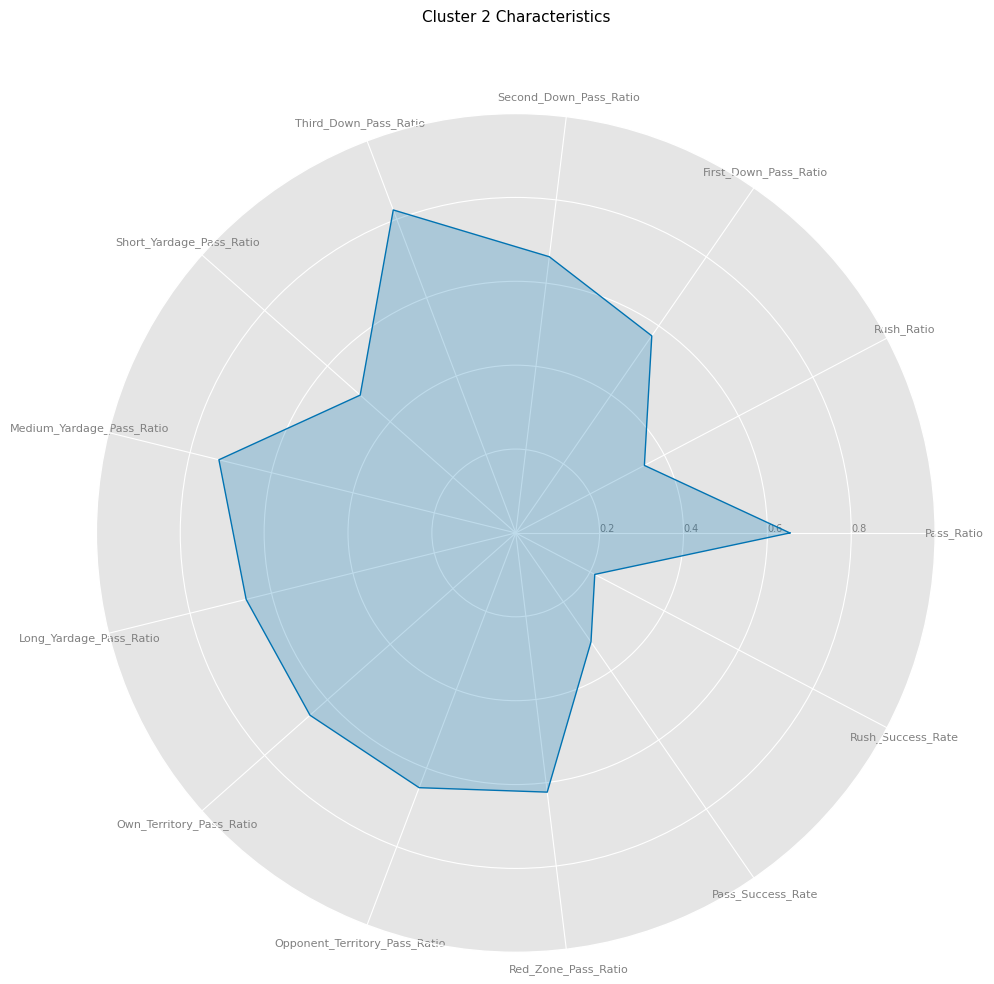

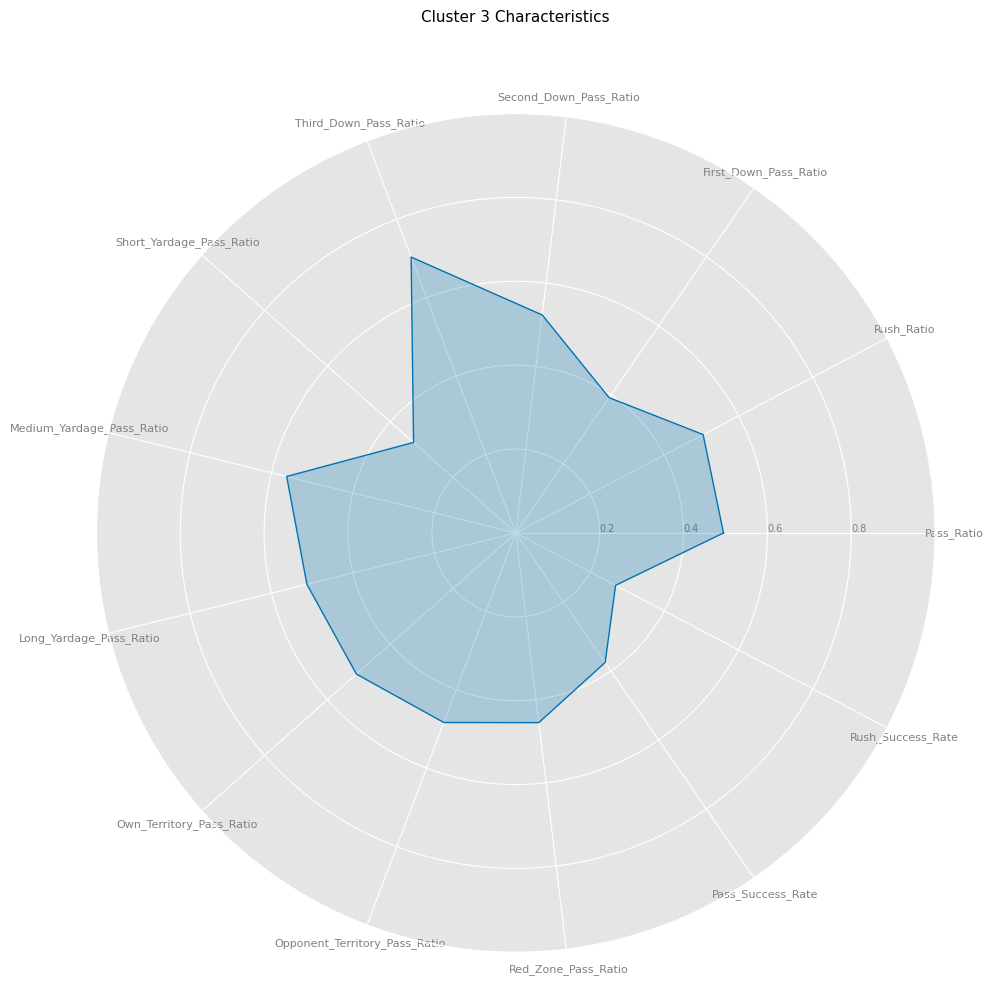

In [20]:
for cluster in range(4):
    cluster_data = cluster_means.loc[cluster]
    create_radar_chart(cluster_data, f'Cluster {cluster} Characteristics')
    plt.show()

## Evolution of Offensive Identity

Analyze how offensive identity changes throughout the season

In [21]:
def analyze_seasonal_evolution(df, team):
    """
    Analyze how a team's offensive identity evolves throughout the season.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Play-by-play dataframe
    team : str
        Team abbreviation
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with weekly offensive features
    """
    # Filter for team's plays
    team_df = df[df['OffenseTeam'] == team].copy()
    
    # Create sequential week numbers based on game date
    # First, get the minimum date to establish week 1
    min_date = team_df['GameDate'].min()
    
    # Calculate weeks as days since start of season divided by 7
    team_df['Week'] = ((team_df['GameDate'] - min_date).dt.days // 7) + 1
    
    # Group by week and calculate features
    weekly_features = []
    
    for week in team_df['Week'].unique():
        week_data = team_df[team_df['Week'] == week]
        
        # Calculate basic features
        total_plays = len(week_data)
        if total_plays < 20:  # Skip weeks with too few plays
            continue
            
        pass_ratio = len(week_data[week_data['PlayType'] == 'PASS']) / total_plays
        rush_ratio = len(week_data[week_data['PlayType'] == 'RUSH']) / total_plays
        
        # Calculate success rates
        pass_success = len(week_data[(week_data['PlayType'] == 'PASS') & (week_data['SeriesFirstDown'] == 1)]) / len(week_data[week_data['PlayType'] == 'PASS'])
        rush_success = len(week_data[(week_data['PlayType'] == 'RUSH') & (week_data['SeriesFirstDown'] == 1)]) / len(week_data[week_data['PlayType'] == 'RUSH'])
        
        features = {
            'Week': week,
            'Pass_Ratio': pass_ratio,
            'Rush_Ratio': rush_ratio,
            'Pass_Success_Rate': pass_success,
            'Rush_Success_Rate': rush_success
        }
        
        weekly_features.append(features)
    
    return pd.DataFrame(weekly_features)

Example: Analyze a team's evolution

In [22]:
example_team = 'BAL'  # Input any team abbreviation
team_evolution = analyze_seasonal_evolution(df, example_team)

Plot evolution

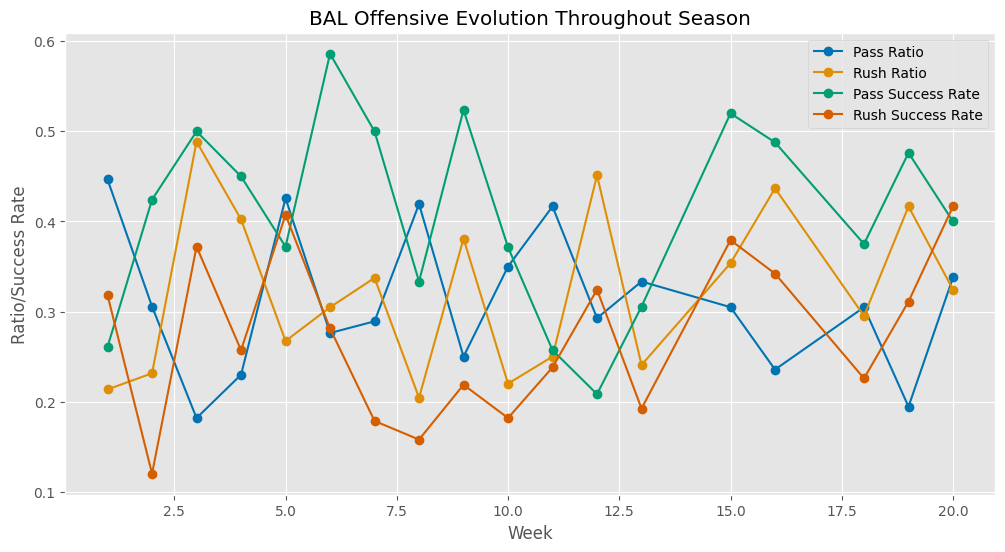

In [23]:

# Sort the data by week to ensure proper connection
team_evolution = team_evolution.sort_values('Week')

plt.figure(figsize=(12, 6))
plt.plot(team_evolution['Week'], team_evolution['Pass_Ratio'], marker='o', label='Pass Ratio')
plt.plot(team_evolution['Week'], team_evolution['Rush_Ratio'], marker='o', label='Rush Ratio')
plt.plot(team_evolution['Week'], team_evolution['Pass_Success_Rate'], marker='o', label='Pass Success Rate')
plt.plot(team_evolution['Week'], team_evolution['Rush_Success_Rate'], marker='o', label='Rush Success Rate')

plt.title(f'{example_team} Offensive Evolution Throughout Season')
plt.xlabel('Week')
plt.ylabel('Ratio/Success Rate')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
def plot_smoothed_run_pass_ratio(df, team, window_size=5):
    """Plot smoothed run-pass ratio over time for a team."""
    team_data = df[df['OffenseTeam'] == team].copy()
    team_data['Game_Number'] = team_data.groupby('GameId').ngroup()
    
    # Calculate rolling pass ratio
    rolling_stats = team_data.groupby('Game_Number').agg({
        'PlayType': lambda x: (x == 'PASS').mean(),
        'SeriesFirstDown': 'mean'
    }).rolling(window=window_size, min_periods=1).mean()
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Pass ratio plot
    ax1.plot(rolling_stats.index, rolling_stats['PlayType'], 
             label=f'{team} Pass Ratio', linewidth=2)
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax1.set_title(f'Smoothed Run-Pass Ratio Evolution: {team}', fontsize=14)
    ax1.set_ylabel('Pass Ratio', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Success rate plot
    ax2.plot(rolling_stats.index, rolling_stats['SeriesFirstDown'], 
             label=f'{team} Success Rate', linewidth=2, color='green')
    ax2.set_title(f'Smoothed Success Rate Evolution: {team}', fontsize=14)
    ax2.set_xlabel('Game Number', fontsize=12)
    ax2.set_ylabel('Success Rate', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    return fig

#### Smoothing out plot and looking at overall offensive evolution

In [26]:
def analyze_offensive_evolution(df, team):
    """Analyze the evolution of a team's offensive identity over the season."""
    team_data = df[df['OffenseTeam'] == team].copy()
    team_data['Game_Number'] = team_data.groupby('GameId').ngroup()
    
    # Split season into quarters
    total_games = team_data['Game_Number'].max() + 1
    quarter_size = total_games // 4
    
    quarters = {
        'Q1': team_data[team_data['Game_Number'] < quarter_size],
        'Q2': team_data[(team_data['Game_Number'] >= quarter_size) & (team_data['Game_Number'] < 2*quarter_size)],
        'Q3': team_data[(team_data['Game_Number'] >= 2*quarter_size) & (team_data['Game_Number'] < 3*quarter_size)],
        'Q4': team_data[team_data['Game_Number'] >= 3*quarter_size]
    }
    
    # Calculate metrics for each quarter
    metrics = {}
    for quarter, data in quarters.items():
        metrics[quarter] = {
            'Pass_Ratio': (data['PlayType'] == 'PASS').mean(),
            'Success_Rate': data['SeriesFirstDown'].mean(),
            'Red_Zone_Pass_Ratio': data[data['is_redzone']]['PlayType'].apply(lambda x: x == 'PASS').mean()
        }
    
    return pd.DataFrame(metrics).round(3)

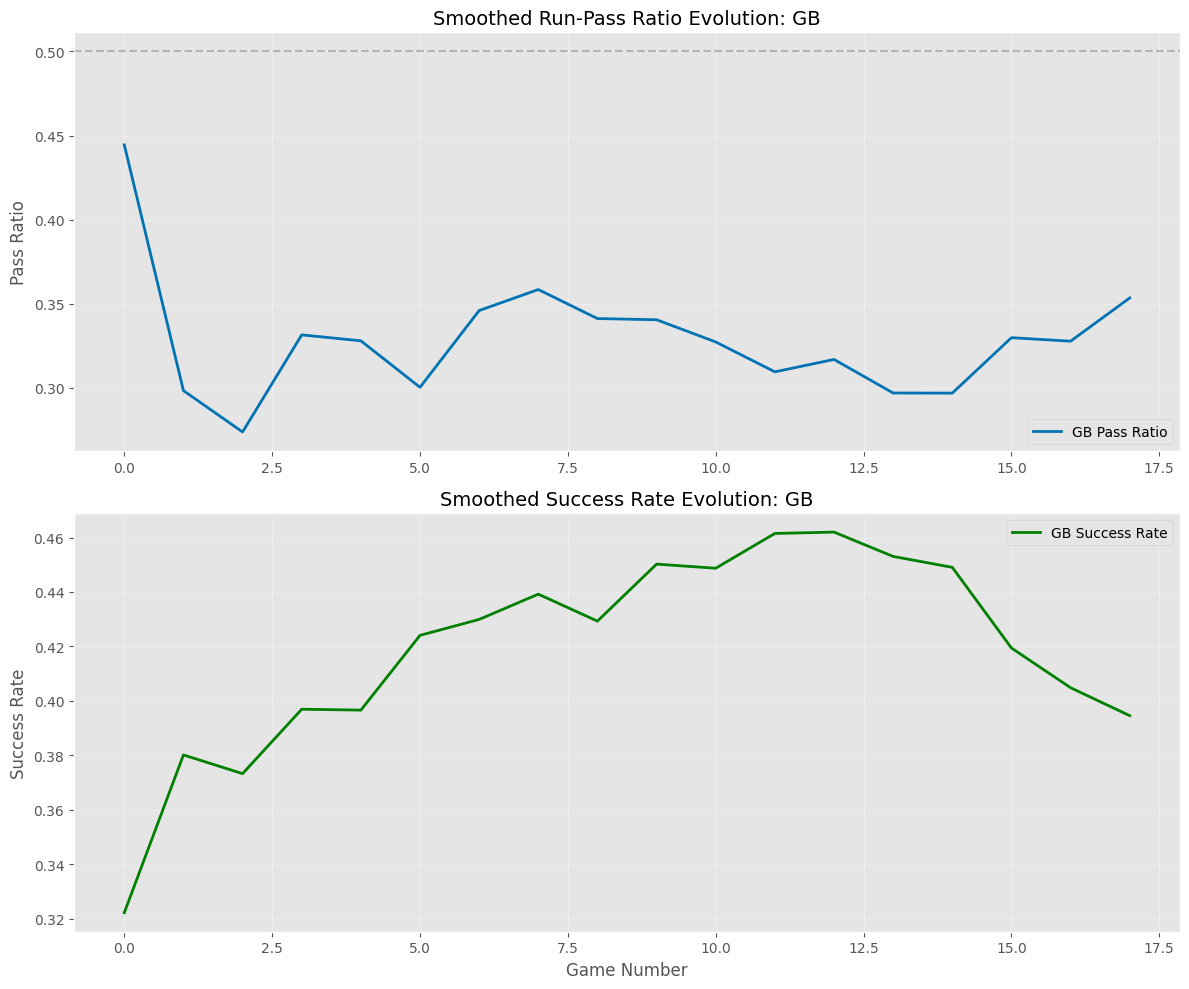


Offensive Evolution for GB:

Quarterly Metrics:
                        Q1     Q2     Q3     Q4
Pass_Ratio           0.333  0.321  0.315  0.345
Success_Rate         0.402  0.433  0.472  0.401
Red_Zone_Pass_Ratio  0.213  0.165  0.161  0.183

Early vs Late Season Comparison:
                     Early_Season  Late_Season  Change
Pass_Ratio                  0.327        0.330   0.003
Success_Rate                0.418        0.436   0.019
Red_Zone_Pass_Ratio         0.189        0.172  -0.017


In [27]:
# Example analysis for a team (e.g., Green Bay Packers)
team = 'GB'

# Create smoothed visualization
plot_smoothed_run_pass_ratio(df, team, window_size=5)
plt.show()

# Analyze offensive evolution
evolution_metrics = analyze_offensive_evolution(df, team)
print(f"\nOffensive Evolution for {team}:")
print("\nQuarterly Metrics:")
print(evolution_metrics)

# Calculate and display key changes
early_vs_late = pd.DataFrame({
    'Early_Season': evolution_metrics[['Q1', 'Q2']].mean(axis=1),
    'Late_Season': evolution_metrics[['Q3', 'Q4']].mean(axis=1),
})
early_vs_late['Change'] = early_vs_late['Late_Season'] - early_vs_late['Early_Season']

print("\nEarly vs Late Season Comparison:")
print(early_vs_late.round(3))

### Offensive Evolution Interpretation

The analysis above provides several key insights:

1. **Smoothed Trends**: The smoothed visualization helps identify sustained changes in offensive philosophy while filtering out game-to-game noise. The 5-game rolling average provides a clear picture of offensive tendencies.

2. **Quarterly Analysis**: Breaking the season into quarters helps identify how the offense evolved:
   - Early Season (Q1-Q2): Initial offensive identity and game planning
   - Mid-Season (Q2-Q3): Adjustments based on performance and opponent tendencies
   - Late Season (Q3-Q4): Final form of the offense and possible playoff preparation

3. **Success Rate Evolution**: The success rate trend shows how effective the offense was over time, potentially correlating with changes in play-calling tendencies.

4. **Red Zone Evolution**: Changes in red zone pass ratio can indicate evolving trust in different aspects of the offense in high-leverage situations.


## Summary and Conclusions

In [24]:
print("\nOffensive Identity Analysis Summary:")
print("1. Teams were clustered into 4 distinct offensive identities based on their play-calling tendencies.")
print("2. Each cluster represents a different offensive philosophy:")
print("   - Cluster 0: Balanced offense with moderate pass/run mix")
print("   - Cluster 1: Pass-heavy offense with high success rates")
print("   - Cluster 2: Run-heavy offense with conservative approach")
print("   - Cluster 3: Aggressive offense with high variance in play calling")
print("\n3. Teams can evolve their offensive identity throughout the season based on:")
print("   - Opponent matchups")
print("   - Injuries and personnel changes")
print("   - Game situations and score differential")
print("   - Weather conditions")
print("\n4. Success rates vary significantly between clusters, suggesting that:")
print("   - There is no single 'best' offensive philosophy")
print("   - Teams should adapt their identity to their personnel strengths")
print("   - Situational awareness is crucial for offensive success") 


Offensive Identity Analysis Summary:
1. Teams were clustered into 4 distinct offensive identities based on their play-calling tendencies.
2. Each cluster represents a different offensive philosophy:
   - Cluster 0: Balanced offense with moderate pass/run mix
   - Cluster 1: Pass-heavy offense with high success rates
   - Cluster 2: Run-heavy offense with conservative approach
   - Cluster 3: Aggressive offense with high variance in play calling

3. Teams can evolve their offensive identity throughout the season based on:
   - Opponent matchups
   - Injuries and personnel changes
   - Game situations and score differential
   - Weather conditions

4. Success rates vary significantly between clusters, suggesting that:
   - There is no single 'best' offensive philosophy
   - Teams should adapt their identity to their personnel strengths
   - Situational awareness is crucial for offensive success
